# Aprendizaje de máquina - Proyecto final

Para este proyecto se eligio el dataset "International football results", disponible en [Kaggle](https://www.kaggle.com/datasets/martj42/international-football-results-from-1872-to-2017), el cual contiene los siguientes datos:
- date: Fecha del partido
- home_team: nombre del equipo local
- away_team: nombre del equipo visitante
- home_score: goles del equipo local
- away_score: goles del equipo visitante
- tournament: nombre del torneo (amistoso, copa mundial, etc.)
- city: ciudad donde se jugó el partido
- country: país donde se jugó el partido
- neutral: indica si el partido se jugó en un campo neutral

Como **objetivo** se plantea predecir el resultado de los partidos (win, draw, lose).

In [39]:
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 130        # plts más nítidos
plt.rcParams["figure.autolayout"] = True
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from category_encoders import TargetEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')


##### 1) EDA: Comprensión inicial del dataset, estadísticas descriptivas, identificación de variables, visualizaciones para entender distribuciones, correlaciones y posibles problemas como valores nulos o atípico.

In [10]:
results = pd.read_csv("./archive/results.csv", parse_dates=["date"])
#results["date"] = pd.to_datetime(results["date"], dayfirst=True, errors="coerce")
results["date"] = pd.to_datetime(results["date"], format="mixed", dayfirst=True, errors="coerce")

In [11]:
print("Dimensiones del dataset: ", results.shape)
results.head()

Dimensiones del dataset:  (48532, 9)


,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


Vemos si el dataset contiene valores nulos y duplicados:

In [14]:
print("Valores nulos:\n", results.isna().sum())
print("\nValores duplicados: ", results.duplicated().sum())

Valores nulos:
 date          0
home_team     0
away_team     0
home_score    0
away_score    0
tournament    0
city          0
country       0
neutral       0
dtype: int64

Valores duplicados:  0


In [15]:
# OM: revisar estructura del dataset
results.info()
[results.head(5), results.tail(5)]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48532 entries, 0 to 48531
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        48532 non-null  datetime64[ns]
 1   home_team   48532 non-null  object        
 2   away_team   48532 non-null  object        
 3   home_score  48532 non-null  int64         
 4   away_score  48532 non-null  int64         
 5   tournament  48532 non-null  object        
 6   city        48532 non-null  object        
 7   country     48532 non-null  object        
 8   neutral     48532 non-null  bool          
dtypes: bool(1), datetime64[ns](1), int64(2), object(5)
memory usage: 3.0+ MB


[        date home_team away_team  home_score  away_score tournament     city  \
 0 1872-11-30  Scotland   England           0           0   Friendly  Glasgow   
 1 1873-03-08   England  Scotland           4           2   Friendly   London   
 2 1874-03-07  Scotland   England           2           1   Friendly  Glasgow   
 3 1875-03-06   England  Scotland           2           2   Friendly   London   
 4 1876-03-04  Scotland   England           3           0   Friendly  Glasgow   
 
     country  neutral  
 0  Scotland    False  
 1   England    False  
 2  Scotland    False  
 3   England    False  
 4  Scotland    False  ,
             date               home_team away_team  home_score  away_score  \
 48527 2025-09-09  Bosnia and Herzegovina   Austria           1           2   
 48528 2025-09-09                  Cyprus   Romania           2           2   
 48529 2025-09-09                  Norway   Moldova          11           1   
 48530 2025-09-09                 Albania    Latvia

In [ ]:
# OM Cuántos torneos únicos hay en el dataset?
results["tournament"].nunique()

188

In [16]:
# OM ¿Cuál es la fecha del primer partido de copas del mundo  de la FIFA (1930 no tuvo clasificación para la Copa Mundial)?
results.loc[results["tournament"] == "FIFA World Cup", "date"].min()

Timestamp('1930-07-13 00:00:00')

In [17]:
# OM Filtrar el dataset para quedarnos solo con los partidos jugados desde la fecha del primer partido de copa del mundo de la FIFA en adelante. ¿Cuántos partidos hay en este subconjunto? 
results_filtrado = results[results["date"].dt.date >= pd.to_datetime(results.loc[results["tournament"] == "FIFA World Cup", "date"].min()).date()]
results_filtrado["tournament"].value_counts()

tournament
Friendly                                17276
FIFA World Cup qualification             8529
UEFA Euro qualification                  2824
African Cup of Nations qualification     2278
FIFA World Cup                            964
                                        ...  
TIFOCO Tournament                           1
Copa Confraternidad                         1
ConIFA Challenger Cup                       1
Benedikt Fontana Cup                        1
South Asian Super Cup                       1
Name: count, Length: 181, dtype: int64

In [ ]:
# OM Cuántos torneos únicos hay en este subconjunto?
results_filtrado["tournament"].nunique()

181

In [28]:
# OM: A partir de aquí desarrollo el modelo predictivo

# Crear la columna target win/draw/loss basada en el resultado del partido
results_filtrado["goal_diff"] = results_filtrado["home_score"] - results_filtrado["away_score"]

# np.select por defecto usa 0 como default (entero), lo que genera conflicto de dtype con strings.
# Se especifica un default de tipo string para evitar el TypeError.
#results_filtrado["target"] = np.select(
#    [results_filtrado["goal_diff"] > 0, results_filtrado["goal_diff"] == 0, results_filtrado["goal_diff"] < 0],
#    ["win", "draw", "loss"],
#    default="unknown"
#)

results_filtrado = results_filtrado.copy()
sign_map = {1: "win", 0: "draw", -1: "loss"}
results_filtrado["target"] = np.sign(results_filtrado["goal_diff"]).map(sign_map)

# sanity check
assert results_filtrado["target"].isna().sum() == 0

Distribución del target:
target
win     0.489
loss    0.282
draw    0.229
Name: proportion, dtype: float64

Classification report (test):
              precision    recall  f1-score   support

        draw      0.265     0.135     0.179      2156
        loss      0.490     0.447     0.468      2651
         win      0.596     0.763     0.669      4603

    accuracy                          0.530      9410
   macro avg      0.450     0.448     0.438      9410
weighted avg      0.490     0.530     0.500      9410



<Figure size 450x400 with 0 Axes>

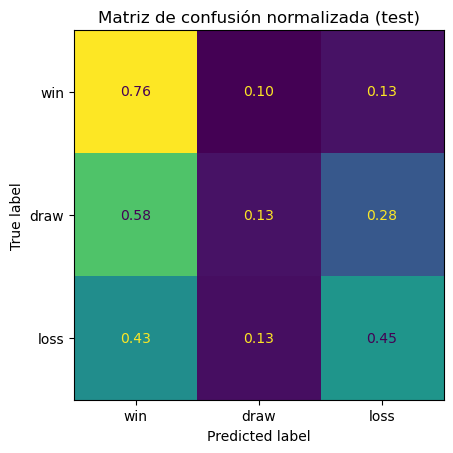


Top 12 importancias:
away_team     0.244065
home_team     0.229111
year          0.214052
month         0.116836
dayofweek     0.099395
tournament    0.085647
neutral       0.010894
dtype: float64


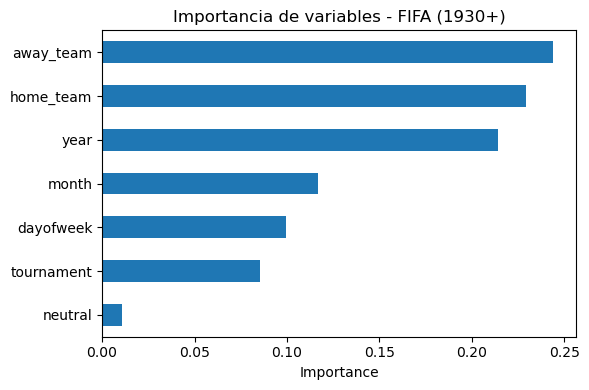

In [30]:
# Distribución (opcional)
print("Distribución del target:")
print(results_filtrado["target"].value_counts(normalize=True).round(3))

# =========================================
# 4) FEATURES base (roles explícitos + numéricas)
# =========================================
results_filtrado["year"] = results_filtrado["date"].dt.year
results_filtrado["month"] = results_filtrado["date"].dt.month
results_filtrado["dayofweek"] = results_filtrado["date"].dt.dayofweek
results_filtrado["neutral"] = results_filtrado["neutral"].astype(int)

feat_cat = ["home_team", "away_team", "tournament"]
feat_num = ["neutral", "year", "month", "dayofweek"]

X = results_filtrado[feat_cat + feat_num]
y = results_filtrado["target"]

# =========================================
# 5) SPLIT antes de cualquier fit (evita leakage)
# =========================================
from sklearn.model_selection import train_test_split

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# =========================================
# 6) PREPROCESAMIENTO con ColumnTransformer
#    - TargetEncoder separado por columna (roles explícitos)
#    - Numéricas pasan "as is"
# =========================================
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import category_encoders as ce

pre = ColumnTransformer(
    transformers=[
        # Cada TargetEncoder aprende su mapping usando SOLO el fold de train dentro del Pipeline
        ("home_te", ce.TargetEncoder(handle_missing="value", handle_unknown="value"), ["home_team"]),
        ("away_te", ce.TargetEncoder(handle_missing="value", handle_unknown="value"), ["away_team"]),
        ("tour_te", ce.TargetEncoder(handle_missing="value", handle_unknown="value"), ["tournament"]),
        ("num", "passthrough", feat_num),
    ],
    remainder="drop",
    verbose_feature_names_out=False  # nombres de salida más limpios
)

# =========================================
# 7) MODELO (baseline robusto)
# =========================================
clf = Pipeline(steps=[
    ("pre", pre),
    ("rf", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        n_jobs=-1,
        class_weight="balanced"  # para que 'draw' no quede sub-representado
    ))
])

clf.fit(X_tr, y_tr)

# =========================================
# 8) EVALUACIÓN
# =========================================
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = clf.predict(X_te)

print("\nClassification report (test):")
print(classification_report(y_te, y_pred, digits=3))

cm = confusion_matrix(y_te, y_pred, labels=["win","draw","loss"], normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["win","draw","loss"])
plt.figure(figsize=(4.5,4))
disp.plot(values_format=".2f", cmap=None, colorbar=False)
plt.title("Matriz de confusión normalizada (test)")
plt.show()

# =========================================
# 9) IMPORTANCIA DE VARIABLES
#    Nota: tras el preprocesamiento, obtenemos los nombres de features
# =========================================
try:
    # Nombres de salida del ColumnTransformer
    feature_names = clf.named_steps["pre"].get_feature_names_out()
except Exception:
    # Fallback si la versión no soporta get_feature_names_out()
    feature_names = np.array(
        ["home_team_TE", "away_team_TE", "tournament_TE"] + feat_num
    )

# Importancias desde el RandomForest dentro del Pipeline
rf = clf.named_steps["rf"]
importances = pd.Series(rf.feature_importances_, index=feature_names).sort_values(ascending=False)

print("\nTop 12 importancias:")
print(importances.head(12))

plt.figure(figsize=(6,4))
importances.head(12).sort_values().plot(kind="barh")
plt.title("Importancia de variables - FIFA (1930+)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [ ]:
# OM: Vamos a comparar contra los resultados originales del dataset (Predicción Vs. Realidad)

# --- Comparación fila a fila real vs predicho ---
comparacion = X_te.copy()
comparacion["real"] = y_te.values
comparacion["predicho"] = y_pred
comparacion["ok"] = comparacion["real"] == comparacion["predicho"]

# Proporción de aciertos
print("\nProporción de aciertos global:")
print(comparacion["ok"].value_counts(normalize=True))

# Ejemplo de visualización
print("\nAlgunas predicciones vs realidad:")
print(comparacion.sample(10))


Proporción de aciertos global:
ok
True     0.530074
False    0.469926
Name: proportion, dtype: float64

Algunas predicciones vs realidad:
                    home_team        away_team  \
45972                 Liberia     South Africa   
8880                  Belgium          Germany   
22244                 Romania  North Macedonia   
22331            Saudi Arabia             Mali   
22125             New Zealand        Australia   
37926  British Virgin Islands     Saint Martin   
26807              Martinique             Cuba   
25956                Thailand     Saudi Arabia   
10766                Scotland            Wales   
38019              Montenegro          Moldova   

                                 tournament  neutral  year  month  dayofweek  \
45972  African Cup of Nations qualification        0  2023      3          1   
8880                              UEFA Euro        0  1972      6          2   
22244          FIFA World Cup qualification        0  1997      8     

In [33]:
# OM: Incorporamos un ranking de desempeño de los equipos basado en los últimos 20 partidos o 2 años jugados

from collections import deque
from math import log

# ====== Parámetros ======
R0 = 1500.0
K_base = 20.0
HOME_ADV = 80.0           # ventaja local en puntos ELO
half_life_years = 2.0     # half-life (2 o 3 años suelen andar muy bien)
half_life_days  = 365.0 * half_life_years
N_prev = 20               # ← cantidad de partidos “hacia atrás” por equipo

# Pesos por torneo (ajustables). Default = 1.1 como pediste.
weights = {
    "FIFA World Cup": 1.6,
    "UEFA European Championship": 1.4,
    "Copa América": 1.4,
    "FIFA World Cup qualification": 1.3,
    "UEFA Nations League": 1.2,
    "Friendly": 0.9,
}
def w_tournament(t):
    return weights.get(t, 1.1)  # ← default sensato

def elo_expect(Ra, Rb, home_adv):
    return 1.0 / (1.0 + 10.0 ** ((Rb - (Ra + home_adv)) / 400.0))

# ====== Estado del ranking ======
ratings = {}             # rating actual por team
last_played = {}         # última fecha jugada por team
recent_counts = {}       # deque de fechas recientes por team (para contar <= N_prev rápido)

snapshots = []

df = results_filtrado.sort_values("date").copy()  # aseguramos orden temporal

for _, row in df.iterrows():
    d   = row["date"]
    ht  = row["home_team"]; at  = row["away_team"]
    hs  = row["home_score"]; as_ = row["away_score"]
    tour = row["tournament"]; neut = bool(row["neutral"])

    # init estructuras si no existen
    if ht not in ratings: ratings[ht] = R0
    if at not in ratings: ratings[at] = R0
    if ht not in recent_counts: recent_counts[ht] = deque(maxlen=N_prev)
    if at not in recent_counts: recent_counts[at] = deque(maxlen=N_prev)

    # --- Decaimiento temporal hacia R0 si pasó tiempo sin jugar ---
    for team in (ht, at):
        if team in last_played:
            delta_days = (d - last_played[team]).days
            if delta_days > 0:
                decay = 0.5 ** (delta_days / half_life_days)
                ratings[team] = R0 + (ratings[team] - R0) * decay

    Rh, Ra = ratings[ht], ratings[at]

    # --- Probabilidades esperadas con ventaja local (si no es neutral) ---
    home_adv = 0.0 if neut else HOME_ADV
    Eh = elo_expect(Rh, Ra, home_adv)
    Ea = 1.0 - Eh

    # --- Resultado real (POV local) ---
    if   hs > as_: Sh, Sa = 1.0, 0.0
    elif hs < as_: Sh, Sa = 0.0, 1.0
    else:          Sh, Sa = 0.5, 0.5

    # --- Margen de victoria suavizado (opcional) ---
    margin = max(1.0, log(1 + abs(hs - as_), 2))  # log base 2

    # --- K dinámico por torneo + margen ---
    Kw_base = K_base * w_tournament(tour) * margin

    # --- Factor por cantidad de partidos recientes (N_prev) ---
    #   Si un equipo tiene menos de N_prev previos, reducimos su K para no sobre-reaccionar.
    cnt_h = len(recent_counts[ht])
    cnt_a = len(recent_counts[at])
    factor_h = min(1.0, cnt_h / N_prev)
    factor_a = min(1.0, cnt_a / N_prev)

    Kw_h = Kw_base * (0.5 + 0.5 * factor_h)  # nunca cero: mínimo 0.5x para que igual aprenda
    Kw_a = Kw_base * (0.5 + 0.5 * factor_a)

    # --- Actualización ELO por lado ---
    ratings[ht] = Rh + Kw_h * (Sh - Eh)
    ratings[at] = Ra + Kw_a * (Sa - Ea)

    # --- Actualizamos contadores y última fecha ---
    recent_counts[ht].append(d)
    recent_counts[at].append(d)
    last_played[ht] = d
    last_played[at] = d

    # --- Guardamos snapshot para merge posterior ---
    snapshots.append({
        "date": d,
        "home_team": ht, "away_team": at,
        "home_rating": ratings[ht],
        "away_rating": ratings[at]
    })

ratings_df = pd.DataFrame(snapshots).sort_values("date").reset_index(drop=True)

# Merge al dataset y feature final
results_with_rating = df.merge(
    ratings_df, on=["date","home_team","away_team"], how="left"
)
results_with_rating["rating_diff"] = results_with_rating["home_rating"] - results_with_rating["away_rating"]



Classification report con rating_diff:
              precision    recall  f1-score   support

        draw      0.371     0.159     0.223      2156
        loss      0.627     0.686     0.655      2651
         win      0.697     0.846     0.764      4604

    accuracy                          0.643      9411
   macro avg      0.565     0.564     0.547      9411
weighted avg      0.603     0.643     0.609      9411



<Figure size 450x400 with 0 Axes>

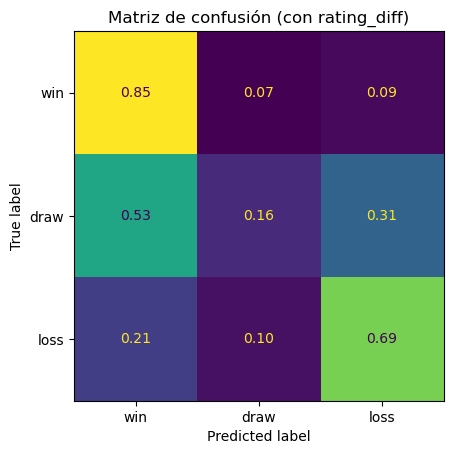


Top 10 importancias:
rating_diff    0.343256
away_team      0.153122
home_team      0.143469
year           0.134812
month          0.082650
tournament     0.066367
dayofweek      0.065721
neutral        0.010604
dtype: float64


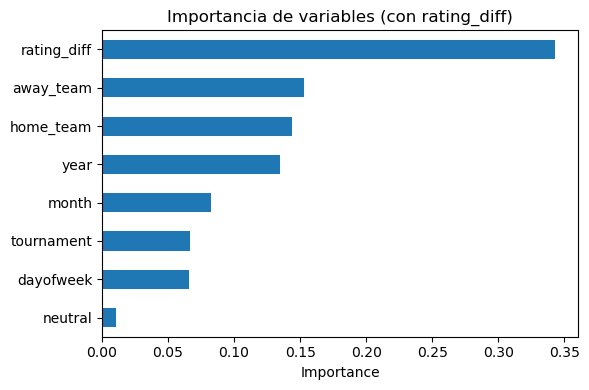

In [34]:
# OM: modelamos de nuevo con la feature adicional de rating_diff

# --- Features ---
feat_cat = ["home_team", "away_team", "tournament"]
feat_num = ["neutral", "year", "month", "dayofweek", "rating_diff"]

X = results_with_rating[feat_cat + feat_num]
y = results_with_rating["target"]

# --- Split ---
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

# --- Preprocesamiento + Modelo ---
pre = ColumnTransformer(
    transformers=[
        ("home_te", ce.TargetEncoder(handle_missing="value", handle_unknown="value"), ["home_team"]),
        ("away_te", ce.TargetEncoder(handle_missing="value", handle_unknown="value"), ["away_team"]),
        ("tour_te", ce.TargetEncoder(handle_missing="value", handle_unknown="value"), ["tournament"]),
        ("num", "passthrough", feat_num),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

clf = Pipeline(steps=[
    ("pre", pre),
    ("rf", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        n_jobs=-1,
        class_weight="balanced"
    ))
])

# --- Fit ---
clf.fit(X_tr, y_tr)

# --- Predicciones ---
y_pred = clf.predict(X_te)
y_proba = clf.predict_proba(X_te)

# --- Reporte ---
print("\nClassification report con rating_diff:")
print(classification_report(y_te, y_pred, digits=3))

# --- Matriz de confusión normalizada ---
cm = confusion_matrix(y_te, y_pred, labels=["win","draw","loss"], normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["win","draw","loss"])
plt.figure(figsize=(4.5,4))
disp.plot(values_format=".2f", cmap=None, colorbar=False)
plt.title("Matriz de confusión (con rating_diff)")
plt.show()

# --- Importancia de features ---
try:
    feature_names = clf.named_steps["pre"].get_feature_names_out()
except Exception:
    feature_names = np.array(["home_team_TE","away_team_TE","tournament_TE"] + feat_num)

importances = pd.Series(clf.named_steps["rf"].feature_importances_, index=feature_names).sort_values(ascending=False)

print("\nTop 10 importancias:")
print(importances.head(10))

plt.figure(figsize=(6,4))
importances.head(10).sort_values().plot(kind="barh")
plt.title("Importancia de variables (con rating_diff)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [ ]:
# Comparamos métricas de acierto global

comparacion = X_te.copy()
comparacion["real"] = y_te.values
comparacion["predicho"] = y_pred
comparacion["ok"] = comparacion["real"] == comparacion["predicho"]

print("\nProporción de aciertos global (modelo con rating_diff):")
print(comparacion["ok"].value_counts(normalize=True))



Proporción de aciertos global (modelo con rating_diff):
ok
True     0.643396
False    0.356604
Name: proportion, dtype: float64


In [43]:
# Cómo resulta versus la predicción anterior antes de correr el nuevo modelo:
# y_pred_old = clf_sin_rating.predict(X_te_old)

import category_encoders as ce
from sklearn.metrics import classification_report

# ---- 0) Alinear filas entre datasets (evitamos NaN en rating_diff)
base_df   = results_filtrado.copy()
plus_df   = results_with_rating.copy()  # tiene home_rating, away_rating, rating_diff

# ============================================
# 0) Alineación robusta por claves (merge)
# ============================================

# Asegúrate de que results_filtrado ya tenga estas columnas temporales creadas.
if not {"year","month","dayofweek"}.issubset(results_filtrado.columns):
    tmp = results_filtrado.copy()
    tmp["year"] = tmp["date"].dt.year
    tmp["month"] = tmp["date"].dt.month
    tmp["dayofweek"] = tmp["date"].dt.dayofweek
else:
    tmp = results_filtrado.copy()

# Hacemos merge para traer ratings al dataset base por claves únicas del partido
merged = tmp.merge(
    results_with_rating[["date","home_team","away_team","home_rating","away_rating","rating_diff"]],
    on=["date","home_team","away_team"],
    how="left"
)

# Filtramos SOLO partidos con rating_diff disponible (por si algo quedó sin calcular)
merged = merged.loc[merged["rating_diff"].notna()].reset_index(drop=True)

# Creamos versiones "base" (sin rating_diff) y "plus" (con rating_diff), YA ALINEADAS
base_df = merged.drop(columns=["home_rating","away_rating","rating_diff"], errors="ignore").copy()
plus_df = merged.copy()

# (si aún no tenés el 'target' en merged, créalo aquí)
if "target" not in base_df.columns:
    base_df["goal_diff"] = base_df["home_score"] - base_df["away_score"]
    sign_map = {1: "win", 0: "draw", -1: "loss"}
    base_df["target"] = np.sign(base_df["goal_diff"]).map(sign_map)

if "target" not in plus_df.columns:
    plus_df["goal_diff"] = plus_df["home_score"] - plus_df["away_score"]
    sign_map = {1: "win", 0: "draw", -1: "loss"}
    plus_df["target"] = np.sign(plus_df["goal_diff"]).map(sign_map)

# ---- 1) Definir features y target para ambos
feat_cat = ["home_team", "away_team", "tournament"]
feat_num_base = ["neutral","year","month","dayofweek"]
feat_num_plus = feat_num_base + ["rating_diff"]

X_base = base_df[feat_cat + feat_num_base]
X_plus = plus_df[feat_cat + feat_num_plus]
y      = base_df["target"]  # mismo target para ambos

# ---- 2) Un solo split de ÍNDICES y se reutiliza en ambos modelos
idx = np.arange(len(y))
idx_tr, idx_te = train_test_split(idx, test_size=0.20, random_state=42, stratify=y)

Xb_tr, Xb_te = X_base.iloc[idx_tr], X_base.iloc[idx_te]
Xp_tr, Xp_te = X_plus.iloc[idx_tr], X_plus.iloc[idx_te]
y_tr,  y_te  = y.iloc[idx_tr],      y.iloc[idx_te]

# ---- 3) Preprocesamiento (TargetEncoder por rol) y modelos
pre_base = ColumnTransformer(
    transformers=[
        ("home_te", ce.TargetEncoder(handle_missing="value", handle_unknown="value"), ["home_team"]),
        ("away_te", ce.TargetEncoder(handle_missing="value", handle_unknown="value"), ["away_team"]),
        ("tour_te", ce.TargetEncoder(handle_missing="value", handle_unknown="value"), ["tournament"]),
        ("num", "passthrough", feat_num_base),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

pre_plus = ColumnTransformer(
    transformers=[
        ("home_te", ce.TargetEncoder(handle_missing="value", handle_unknown="value"), ["home_team"]),
        ("away_te", ce.TargetEncoder(handle_missing="value", handle_unknown="value"), ["away_team"]),
        ("tour_te", ce.TargetEncoder(handle_missing="value", handle_unknown="value"), ["tournament"]),
        ("num", "passthrough", feat_num_plus),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

clf_old = Pipeline([
    ("pre", pre_base),
    ("rf", RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1, class_weight="balanced"))
])
clf_new = Pipeline([
    ("pre", pre_plus),
    ("rf", RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1, class_weight="balanced"))
])

# ---- 4) Entrenar ambos y guardar predicciones
clf_old.fit(Xb_tr, y_tr)
y_pred_old = clf_old.predict(Xb_te)

clf_new.fit(Xp_tr, y_tr)
y_pred_new = clf_new.predict(Xp_te)

print("\n== Reporte MODELO VIEJO (sin rating_diff) ==")
print(classification_report(y_te, y_pred_old, digits=3))

print("\n== Reporte MODELO NUEVO (con rating_diff) ==")
print(classification_report(y_te, y_pred_new, digits=3))

# ---- 5) Comparación fila a fila (lado a lado)
comparacion = Xp_te.copy()  # cualquiera de los dos X_te sirve; tienen los mismos idx
comparacion["real"]         = y_te.values
comparacion["predicho_old"] = y_pred_old
comparacion["predicho_new"] = y_pred_new
comparacion["mejoró"]  = (comparacion["predicho_new"] == comparacion["real"]) & (comparacion["predicho_old"] != comparacion["real"])
comparacion["empeoró"] = (comparacion["predicho_new"] != comparacion["real"]) & (comparacion["predicho_old"] == comparacion["real"])

print("\nResumen comparativo:")
print("Accuracy viejo:", (comparacion["predicho_old"] == comparacion["real"]).mean())
print("Accuracy nuevo:", (comparacion["predicho_new"] == comparacion["real"]).mean())
print("Partidos que MEJORÓ:", comparacion["mejoró"].sum())
print("Partidos que EMPEORÓ:", comparacion["empeoró"].sum())


== Reporte MODELO VIEJO (sin rating_diff) ==
              precision    recall  f1-score   support

        draw      0.265     0.133     0.177      2157
        loss      0.493     0.448     0.469      2652
         win      0.594     0.765     0.669      4604

    accuracy                          0.531      9413
   macro avg      0.451     0.448     0.438      9413
weighted avg      0.490     0.531     0.500      9413


== Reporte MODELO NUEVO (con rating_diff) ==
              precision    recall  f1-score   support

        draw      0.328     0.142     0.199      2157
        loss      0.627     0.686     0.655      2652
         win      0.691     0.837     0.757      4604

    accuracy                          0.635      9413
   macro avg      0.549     0.555     0.537      9413
weighted avg      0.590     0.635     0.600      9413


Resumen comparativo:
Accuracy viejo: 0.5305428662488049
Accuracy nuevo: 0.6352916179751408
Partidos que MEJORÓ: 1607
Partidos que EMPEORÓ: 621



Resumen comparativo de métricas:


,Clase,Precision_old,Recall_old,F1_old,Precision_new,Recall_new,F1_new
0,win,0.594,0.765,0.669,0.691,0.837,0.757
1,draw,0.265,0.133,0.177,0.328,0.142,0.199
2,loss,0.493,0.448,0.469,0.627,0.686,0.655
3,Global,0.531,0.531,0.531,0.635,0.635,0.635


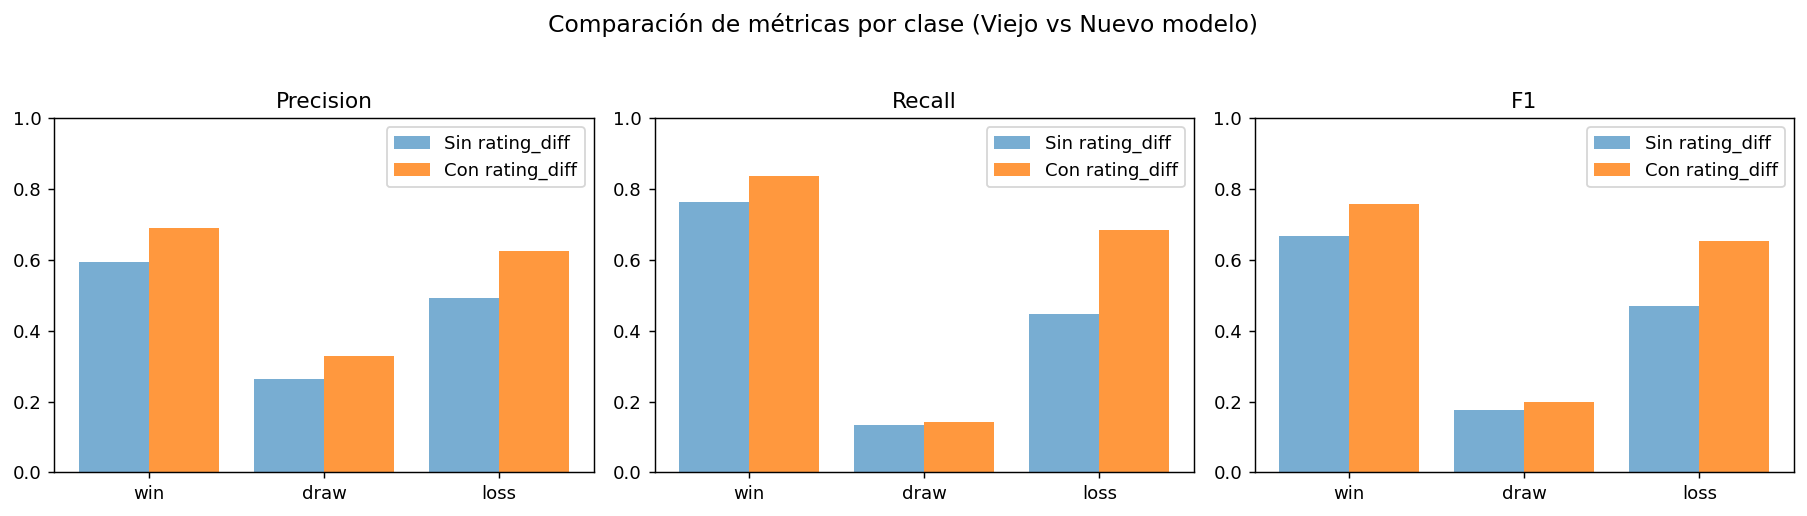

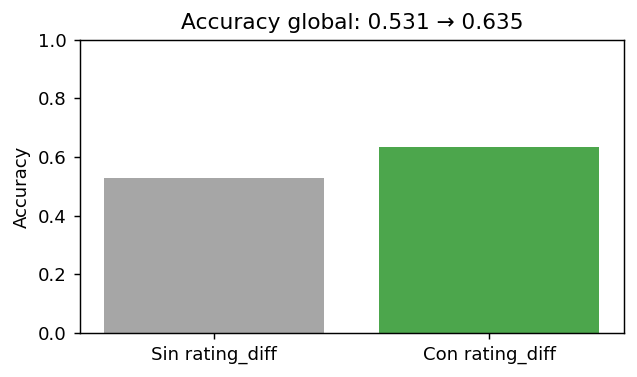

In [44]:
# ============================================================
# 6) Comparación visual: performance viejo vs nuevo
# ============================================================

from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# --- Métricas por clase ---
labels = ["win", "draw", "loss"]

prec_old, rec_old, f1_old, _ = precision_recall_fscore_support(y_te, y_pred_old, labels=labels, zero_division=0)
prec_new, rec_new, f1_new, _ = precision_recall_fscore_support(y_te, y_pred_new, labels=labels, zero_division=0)

acc_old = accuracy_score(y_te, y_pred_old)
acc_new = accuracy_score(y_te, y_pred_new)

# --- DataFrame resumen ---
df_metrics = pd.DataFrame({
    "Clase": labels + ["Global"],
    "Precision_old": list(prec_old) + [np.nan],
    "Recall_old": list(rec_old) + [np.nan],
    "F1_old": list(f1_old) + [np.nan],
    "Precision_new": list(prec_new) + [np.nan],
    "Recall_new": list(rec_new) + [np.nan],
    "F1_new": list(f1_new) + [np.nan],
})
df_metrics.loc[df_metrics["Clase"]=="Global", ["Precision_old","Recall_old","F1_old"]] = acc_old
df_metrics.loc[df_metrics["Clase"]=="Global", ["Precision_new","Recall_new","F1_new"]] = acc_new

print("\nResumen comparativo de métricas:")
display(df_metrics.round(3))

# --- Visualización ---
fig, axes = plt.subplots(1, 3, figsize=(14,4))
metricas = ["Precision", "Recall", "F1"]

for i, met in enumerate(metricas):
    axes[i].bar(np.arange(len(labels)), df_metrics[f"{met}_old"][:-1], width=0.4, label="Sin rating_diff", alpha=0.6)
    axes[i].bar(np.arange(len(labels))+0.4, df_metrics[f"{met}_new"][:-1], width=0.4, label="Con rating_diff", alpha=0.8)
    axes[i].set_xticks(np.arange(len(labels))+0.2)
    axes[i].set_xticklabels(labels)
    axes[i].set_title(met)
    axes[i].set_ylim(0,1)
    axes[i].legend()

plt.suptitle("Comparación de métricas por clase (Viejo vs Nuevo modelo)", fontsize=13)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# --- Global accuracy barplot ---
plt.figure(figsize=(5,3))
plt.bar(["Sin rating_diff","Con rating_diff"], [acc_old, acc_new], color=["gray","green"], alpha=0.7)
plt.title(f"Accuracy global: {acc_old:.3f} → {acc_new:.3f}")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.show()


<Figure size 585x520 with 0 Axes>

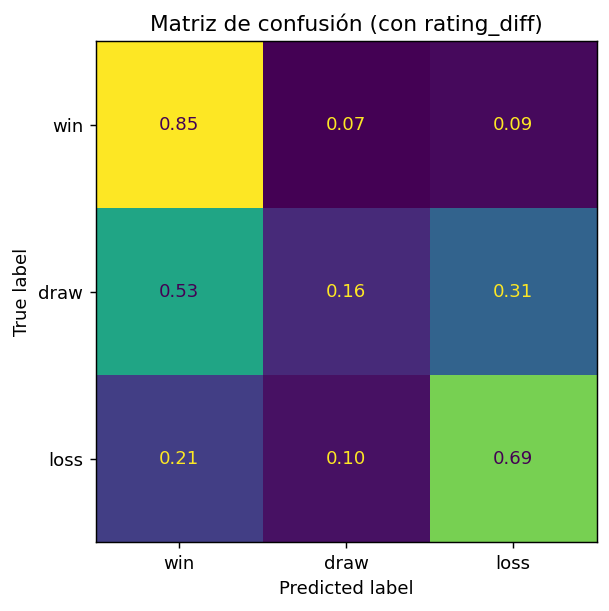

In [45]:
# OM: Matriz de confusión del modelo con rating_diff

plt.figure(figsize=(4.5,4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["win","draw","loss"])
disp.plot(values_format=".2f", colorbar=False)
plt.title("Matriz de confusión (con rating_diff)")
plt.show()


== Reporte con regla de empate (thr=0.45) ==
              precision    recall  f1-score   support

        draw      0.339     0.300     0.319      2157
        loss      0.674     0.618     0.645      2652
         win      0.723     0.796     0.757      4604

    accuracy                          0.632      9413
   macro avg      0.579     0.571     0.574      9413
weighted avg      0.621     0.632     0.625      9413



<Figure size 585x520 with 0 Axes>

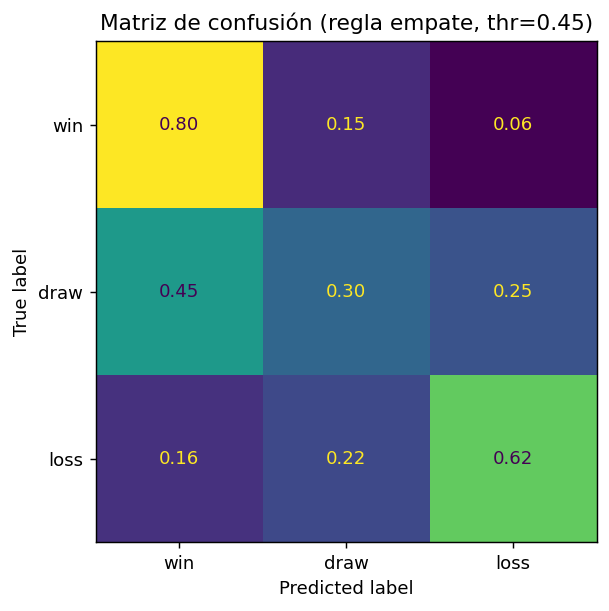


Sensibilidad por umbral (ordenado por macro_f1):
    thr  accuracy  macro_f1  recall_win  recall_draw  recall_loss  f1_win  \
2  0.50     0.617     0.577       0.749        0.412        0.554   0.746   
1  0.45     0.632     0.574       0.796        0.300        0.618   0.757   
3  0.55     0.597     0.571       0.697        0.519        0.487   0.730   
0  0.40     0.639     0.559       0.823        0.208        0.669   0.759   

   f1_draw  f1_loss  
2    0.367    0.618  
1    0.319    0.645  
3    0.398    0.587  
0    0.260    0.659  


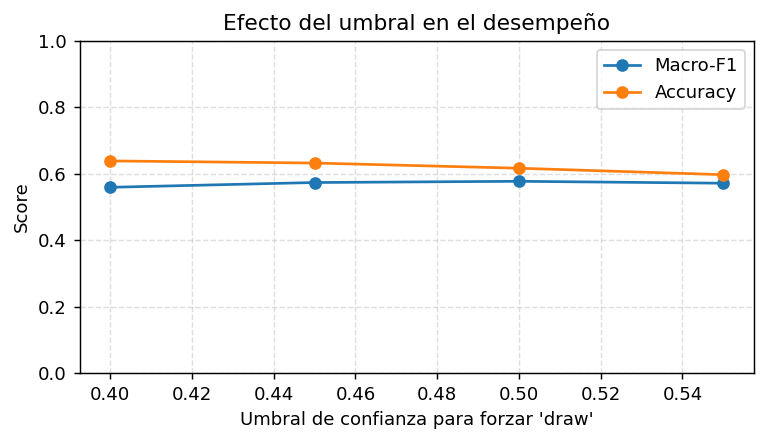

In [46]:
# OM: Empate por baja confianza + evaluación
# (usar después de entrenar clf_new)
# ============================================

# Probabilidades del modelo nuevo
proba = clf_new.predict_proba(Xp_te)
classes = clf_new.classes_

# Función que aplica la regla: si max(p) < thr => "draw", si no => clase argmax
def predict_with_draw_rule(proba, classes, thr=0.45):
    maxp = proba.max(axis=1)
    argmax_idx = proba.argmax(axis=1)
    pred = classes[argmax_idx].astype(object)

    # forzamos "draw" cuando no hay confianza alta en ninguna clase
    pred[maxp < thr] = "draw"
    return pred

# ---------- 1) Evaluación con un umbral base (0.45) ----------
thr = 0.45
y_pred_adj = predict_with_draw_rule(proba, classes, thr)

print(f"\n== Reporte con regla de empate (thr={thr:.2f}) ==")
print(classification_report(y_te, y_pred_adj, digits=3))

cm = confusion_matrix(y_te, y_pred_adj, labels=["win","draw","loss"], normalize="true")
from sklearn.metrics import ConfusionMatrixDisplay
plt.figure(figsize=(4.5,4))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["win","draw","loss"]).plot(values_format=".2f", colorbar=False)
plt.title(f"Matriz de confusión (regla empate, thr={thr:.2f})")
plt.show()

# ---------- 2) Sensibilidad del umbral ----------
thresholds = [0.40, 0.45, 0.50, 0.55]
rows = []
for t in thresholds:
    y_adj = predict_with_draw_rule(proba, classes, t)
    acc = accuracy_score(y_te, y_adj)
    prec, rec, f1, _ = precision_recall_fscore_support(y_te, y_adj, labels=["win","draw","loss"], zero_division=0)
    macro_f1 = f1.mean()
    rows.append({
        "thr": t,
        "accuracy": acc,
        "macro_f1": macro_f1,
        "recall_win": rec[0],
        "recall_draw": rec[1],
        "recall_loss": rec[2],
        "f1_win": f1[0],
        "f1_draw": f1[1],
        "f1_loss": f1[2],
    })

sens = pd.DataFrame(rows)
print("\nSensibilidad por umbral (ordenado por macro_f1):")
print(sens.sort_values("macro_f1", ascending=False).round(3))

# ---------- 3) Gráfico rápido (macro-F1 y accuracy vs umbral) ----------
plt.figure(figsize=(6,3.5))
plt.plot(sens["thr"], sens["macro_f1"], marker="o", label="Macro-F1")
plt.plot(sens["thr"], sens["accuracy"], marker="o", label="Accuracy")
plt.xlabel("Umbral de confianza para forzar 'draw'")
plt.ylabel("Score")
plt.title("Efecto del umbral en el desempeño")
plt.ylim(0, 1)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()


In [48]:
# Probabilidades:
proba = clf_new.predict_proba(Xp_te)
classes = clf_new.classes_
ix_win  = np.where(classes=="win")[0][0]
ix_draw = np.where(classes=="draw")[0][0]
ix_loss = np.where(classes=="loss")[0][0]

def predict_with_draw_rule_2d(proba, classes, thr=0.50, gap=0.10):
    pmax = proba.max(axis=1)
    pw, pd, pl = proba[:, ix_win], proba[:, ix_draw], proba[:, ix_loss]
    pred_idx = proba.argmax(axis=1)
    pred = classes[pred_idx].astype(object)
    # condición doble: poca confianza + p_win y p_loss muy cercanas
    mask_draw = (pmax < thr) & (np.abs(pw - pl) < gap)
    pred[mask_draw] = "draw"
    return pred


In [49]:
# ---------- 4) Sensibilidad doble (thr + gap) ----------
rows = []
for thr in [0.45, 0.50, 0.55]:
    for gap in [0.08, 0.10, 0.12, 0.15]:
        y_adj = predict_with_draw_rule_2d(proba, classes, thr=thr, gap=gap)
        prec, rec, f1, _ = precision_recall_fscore_support(
            y_te, y_adj, labels=["win","draw","loss"], zero_division=0
        )
        rows.append({
            "thr": thr, "gap": gap,
            "accuracy": accuracy_score(y_te, y_adj),
            "macro_f1": f1.mean(),
            "recall_win": rec[0], "recall_draw": rec[1], "recall_loss": rec[2]
        })
sens2 = pd.DataFrame(rows).sort_values("macro_f1", ascending=False)
print(sens2.head(10).round(3))


     thr   gap  accuracy  macro_f1  recall_win  recall_draw  recall_loss
3   0.45  0.15     0.635     0.565       0.813        0.247        0.643
11  0.55  0.15     0.633     0.565       0.809        0.258        0.630
7   0.50  0.15     0.633     0.565       0.810        0.257        0.631
6   0.50  0.12     0.637     0.564       0.818        0.235        0.650
10  0.55  0.12     0.637     0.564       0.818        0.235        0.650
2   0.45  0.12     0.638     0.564       0.819        0.229        0.657
5   0.50  0.10     0.639     0.562       0.823        0.220        0.659
9   0.55  0.10     0.639     0.562       0.823        0.220        0.659
1   0.45  0.10     0.639     0.561       0.824        0.216        0.663
4   0.50  0.08     0.638     0.557       0.826        0.204        0.666


In [51]:
# OM: Extra: incorporar rating_diff en la regla (3D)
# ============================================

rd = Xp_te["rating_diff"].values  # diferencia de rating del set de test

def predict_with_draw_rule_3d(proba, classes, thr=0.45, gap=0.10, rd_max=60):
    ix_win  = np.where(classes == "win")[0][0]
    ix_loss = np.where(classes == "loss")[0][0]
    pmax = proba.max(axis=1)
    pw, pl = proba[:, ix_win], proba[:, ix_loss]
    pred_idx = proba.argmax(axis=1)
    pred = classes[pred_idx].astype(object)
    # condición triple: baja confianza + equilibrio + partido parejo
    mask_draw = (pmax < thr) & (np.abs(pw - pl) < gap) & (np.abs(rd) <= rd_max)
    pred[mask_draw] = "draw"
    return pred

# Pequeño grid de sensibilidad con rating_diff
rows = []
for thr in [0.45, 0.50, 0.55]:
    for gap in [0.08, 0.10, 0.12]:
        for rd_max in [40, 50, 60]:
            y_adj = predict_with_draw_rule_3d(proba, classes, thr=thr, gap=gap, rd_max=rd_max)
            prec, rec, f1, _ = precision_recall_fscore_support(
                y_te, y_adj, labels=["win","draw","loss"], zero_division=0
            )
            rows.append({
                "thr": thr, "gap": gap, "rd_max": rd_max,
                "accuracy": accuracy_score(y_te, y_adj),
                "macro_f1": f1.mean(),
                "recall_win": rec[0], "recall_draw": rec[1], "recall_loss": rec[2],
            })
sens3 = pd.DataFrame(rows).sort_values("macro_f1", ascending=False)
print(sens3.head(10).round(3))


     thr   gap  rd_max  accuracy  macro_f1  recall_win  recall_draw  \
17  0.50  0.12      60     0.636     0.560       0.819        0.221   
26  0.55  0.12      60     0.636     0.560       0.819        0.221   
8   0.45  0.12      60     0.637     0.560       0.820        0.216   
7   0.45  0.12      50     0.638     0.559       0.822        0.210   
16  0.50  0.12      50     0.637     0.559       0.821        0.213   
25  0.55  0.12      50     0.636     0.559       0.821        0.213   
14  0.50  0.10      60     0.638     0.559       0.824        0.209   
23  0.55  0.10      60     0.638     0.558       0.824        0.209   
5   0.45  0.10      60     0.639     0.558       0.825        0.206   
13  0.50  0.10      50     0.638     0.556       0.825        0.202   

    recall_loss  
17        0.658  
26        0.657  
8         0.663  
7         0.666  
16        0.661  
25        0.661  
14        0.664  
23        0.664  
5         0.667  
13        0.666  


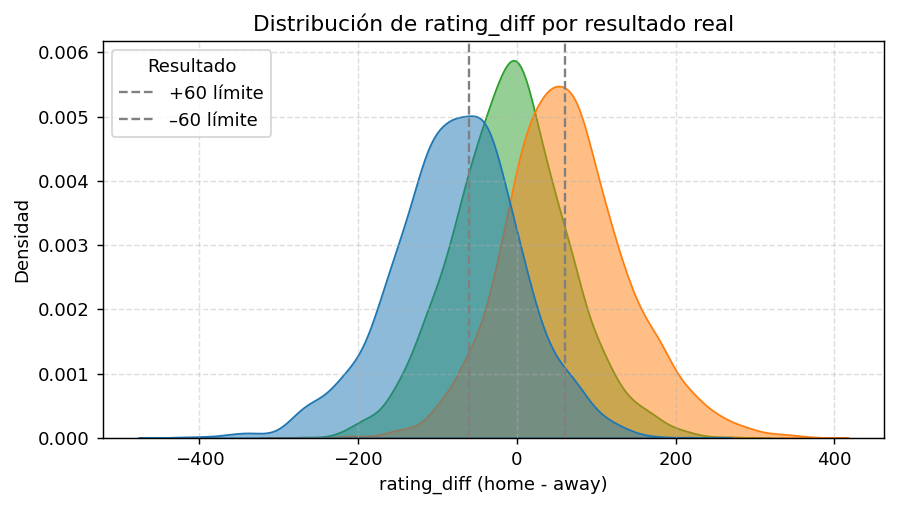

+60 límite → gray
–60 límite → gray


In [54]:
# OM: Visualización de rating_diff para ver el “corte” de partidos parejos
# Dataset de prueba: rating_diff + resultado real
df_plot = pd.DataFrame({
    "rating_diff": Xp_te["rating_diff"],
    "resultado": y_te
})

plt.figure(figsize=(7,4))
ax = sns.kdeplot(
    data=df_plot,
    x="rating_diff",
    hue="resultado",
    fill=True,
    common_norm=False,
    alpha=0.5
)

# === Líneas de corte ===
plt.axvline(60, color="gray", linestyle="--", linewidth=1.3, label="+60 límite")
plt.axvline(-60, color="gray", linestyle="--", linewidth=1.3, label="–60 límite")

plt.title("Distribución de rating_diff por resultado real")
plt.xlabel("rating_diff (home - away)")
plt.ylabel("Densidad")
plt.legend(title="Resultado", loc="upper left")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

# (opcional) Mostrar mapeo de colores en consola
legend = ax.legend_
for txt, line in zip(legend.get_texts(), legend.get_lines()):
    print(f"{txt.get_text():<5} → {line.get_color()}")


#Fin modelo propuesto por OM

Como el dataset original no tiene la variable a predecir, se procede a crearla junto a otras variables utiles para visualizaciones

In [ ]:
results["year"] = results["date"].dt.year
results["month"] = results["date"].dt.month
results["dayofweek"] = results["date"].dt.dayofweek
results["is_weekend"] = results["dayofweek"].apply(lambda x: 1 if x >= 5 else 0)

results["goal_diff"] = abs(results["home_score"] - results["away_score"])
results["total_score"] = results["home_score"] + results["away_score"]

results["result"] = results.apply(
    lambda row: "win" if row["home_score"] > row["away_score"] 
        else ("lose" if row["home_score"] < row["away_score"] else "draw"),
    axis=1)

results.head()

In [ ]:
results.info()

In [ ]:
results.describe()

#### Visualizaciones de variables numéricas

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

ax[0].hist(results['home_score'], bins=20)
ax[0].set_title('home_score')
ax[1].hist(results['away_score'], bins=20)
ax[1].set_title('away_score')

plt.show()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

sns.boxplot(data=results, y="home_score", ax=ax[0])
ax[0].set_title('home_score')
sns.boxplot(data=results, y="away_score", ax=ax[1])
ax[1].set_title('away_score')

plt.show()

📝 Si bien existen outliers, estos no pueden tratarse como errores ya que son resultados reales de partidos de fútbol.

In [ ]:
sns.lineplot(data=results, x="year", y="total_score")
plt.title("Diferencia de goles en el tiempo")
plt.show()

📝 Vemos que la cantidad de goles se fuerón estabilizando con el tiempo, lo cual es un indicio de que el nivel de los equipos se fue igualando.

In [ ]:
sns.boxplot(data=results, y="total_score", hue="result")
plt.title("Total de goles según el resultado")
plt.show()

In [ ]:
corr = results[["home_score", "away_score", "total_score", "goal_diff"]].corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()

#### Visualización de variables categoricas

In [ ]:
results["home_team"] = results["home_team"].astype('category')
results["away_team"] = results["away_team"].astype('category')
results["tournament"] = results["tournament"].astype('category')
results["city"] = results["city"].astype('category')
results["country"] = results["country"].astype('category')
results["result"] = results["result"].astype('category')


In [ ]:
results.describe(include='category')

Veamos la distribución del target

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.countplot(data=results, x="result", order=["win","draw","lose"], ax=ax[0])
ax[0].set_title("Distribución de resultados")

results_counts = results['result'].value_counts()
ax[1].pie(results_counts, labels=results_counts.index, autopct='%1.2f%%', startangle=90, colors=sns.color_palette('pastel'))
ax[1].set_title('Porcentaje de resutados')

plt.show()

📝 A partir de los graficos de los resultados, vemos un cierto desbalance en las clases. Esto podría afectar el rendimiento del modelo, haciendo que aprenda mas la clase mayoritaria (win).

In [ ]:
sns.countplot(data=results, x="result", order=["win","draw","lose"], hue="neutral")
plt.title("Distribución de resultados segun sí el local jugó en su país")
plt.show()

Como la cardinalidad de las variables categoricas es muy alta, vamos a graficar aquellos valores que más se destacan:

In [ ]:
plt.figure(figsize=(10,5))
results["tournament"].value_counts().head(20).plot(kind="bar")
plt.title("Torneos con más partidos jugados")
plt.show()

In [ ]:
plt.figure(figsize=(8, 4))
results["country"].value_counts().head(10).plot(kind="bar")
plt.title("Paises donde se jugaron más partidos")
plt.show()

📝 De los torneos, se destaca el tipo "amistoso" pero también aparecen torneos pocos conocidos a la par de otros mas conocidos a nivel mundial. La cardinalidad de los torneos puede influir al momento de evaluar los modelos.

Con los paises sucede algo similar, paises como Malasia o Tailandia tienen una cantidad de partidos importantes.

In [ ]:
home_winners = results[results["result"] == "win"]
away_winners = results[results["result"] == "lose"]

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

home_winners["home_team"].value_counts().head(10).plot(kind="bar", ax=ax[0])
ax[0].set_title("Equipos más ganadores como local")
away_winners["away_team"].value_counts().head(10).plot(kind="bar", ax=ax[1])
ax[1].set_title("Equipos más ganadores como visitante")
plt.show()

 ##### 2) Preprocesamiento y Preparación de Datos: Descripción de las transformaciones aplicadas a los datos para prepararlos para el modelado. Esto incluye, pero no se limita a: limpieza de datos, imputación de valores faltantes, codificación de variables categóricas, escalado de características, etc.

📝 En base al analisis previo, se decide filtrar los datos a partir de 1920. Antes de esa fecha, había más diferencia entre los equipos (mayor diferencia de goles).

Otros filtros a considerar que pueden introducir ruido en el modelo:
* Cardinalidad de los torneos: existen demasiados torneos por lo cual podría ser conveniente centrarse en los mas conocidos.

In [ ]:
results_filtered = results[results["year"] >= 1920].reset_index(drop=True)

print("Original", results.shape)
print("Filtrado", results_filtered.shape)

📝 Como el objetivo es predecir el resultado del partido, no podemos usar los registros como tal ya que estos son posteriores al partido. Por lo tanto, se crean nuevas variables que representen el rendimiento de los equipos en los últimos partidos jugados, y de esta forma evitamos el *data leakage*. Por ejemplo:
- Tasa de partidos ganados en los últimos N partidos
- Promedio de goles a favor y en contra en los últimos N partidos

In [ ]:
window_size = 10  # cantidad de partidos a considerar

# Calcular winrate del equipo local
results_filtered["home_n_winrate"] = (
    results_filtered.groupby("home_team")["result"]
      .apply(lambda x: x.shift().eq("win").rolling(window_size, min_periods=1).mean())
      .reset_index(level=0, drop=True)
)

# Calcular winrate del equipo visitante
results_filtered['away_n_winrate'] = (
    results_filtered.groupby('away_team')['result']
      .apply(lambda x: x.shift().eq("lose").rolling(window_size, min_periods=1).mean())
      .reset_index(level=0, drop=True)
)


# Promedio de goles a favor
results_filtered['home_n_avg_gf'] = (
    results_filtered.groupby('home_team')['home_score']
      .apply(lambda x: x.shift().rolling(window_size, min_periods=1).mean())
      .reset_index(level=0, drop=True)
)

results_filtered['away_n_avg_gf'] = (
    results_filtered.groupby('away_team')['away_score']
      .apply(lambda x: x.shift().rolling(window_size, min_periods=1).mean())
      .reset_index(level=0, drop=True)
)

# Promedio de goles en contra
results_filtered['home_n_avg_ga'] = (
    results_filtered.groupby('home_team')['away_score']
      .apply(lambda x: x.shift().rolling(window_size, min_periods=1).mean())
      .reset_index(level=0, drop=True)
)

results_filtered['away_n_avg_ga'] = (
    results_filtered.groupby('away_team')['home_score']
      .apply(lambda x: x.shift().rolling(window_size, min_periods=1).mean())
      .reset_index(level=0, drop=True)
)

In [ ]:
print("Nulos en base al procesamiento:\n", results_filtered.isna().sum()[results_filtered.isna().sum() > 0])

Como aparecen valores nulos, se decide imputar estos valores con 1.

In [ ]:
features_nulls = [
    'home_n_avg_gf', 'away_n_avg_gf',
    'home_n_avg_ga', 'away_n_avg_ga',
]

results_filtered[features_nulls] = results_filtered[features_nulls].fillna(1.0)

Codificamos las variables categoricas:
- result se codifica con LabelEncoder por ser la variable a predecir
- home_team, away_team, tournament se codifican con TargetEncoder por tener una cardinalidad alta

In [ ]:
result_encoder = LabelEncoder()
results_filtered["result_enc"] = result_encoder.fit_transform(results_filtered["result"])
print("Clases del resultado: ", result_encoder.classes_)

tournament_encoder = TargetEncoder()
results_filtered["tournament_enc"] = tournament_encoder.fit_transform(results_filtered["tournament"], results_filtered["result_enc"])

home_team_encoder = TargetEncoder()
results_filtered["home_team_enc"] = home_team_encoder.fit_transform(results_filtered["home_team"], results_filtered["result_enc"])

away_team_encoder = TargetEncoder()
results_filtered["away_team_enc"] = away_team_encoder.fit_transform(results_filtered["away_team"], results_filtered["result_enc"])

results_filtered["neutral"] = results_filtered["neutral"].astype(int)

📝 Como el resultado de un partido puede estar influenciado por resultados anteriores (el rendimiento previo que tuvo el equipo), se decide tratar al dataset como una **serie temporal**. Por lo tanto, se divide en conjunto de entrenamiento y prueba según una fecha determinada.

In [ ]:
train = results_filtered[results_filtered["date"] < "2015-01-01"]
test = results_filtered[results_filtered["date"] >= "2015-01-01"]
print(f"Train size: {(len(train)/len(results_filtered))*100:.2f} %")
print(f"Test size: {(len(test)/len(results_filtered))*100:.2f} %")

In [ ]:
# Definimos las features que usaremos para el modelo:
features = [
    'home_n_winrate', 'away_n_winrate',
    'home_n_avg_gf', 'away_n_avg_gf',
    'home_n_avg_ga', 'away_n_avg_ga',
    'neutral', 'tournament_enc',
    'home_team_enc', 'away_team_enc',
    'month', 'is_weekend'
]

target = "result_enc"

X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

Finalmente, se estandarizan las variables para que todas tengan la misma escala.

In [ ]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

##### 3) Modelado: Construcción y entrenamiento de los modelos de aprendizaje automático.

📝 Para modelar el problema, se van a utilizar diferentes algoritmos de clasificación para hacer un analisis comparativo y ver cual se adapta mejor al problema.

In [ ]:
# Modelo baseline: regresión logística multiclase
logreg = LogisticRegression(max_iter=1000, class_weight="balanced")
logreg.fit(X_train, y_train)

y_pred_logreg = logreg.predict(X_test)

#print_classification_results(y_test, y_pred, "Regresión Logística")

In [ ]:
# KNN
knn = KNeighborsClassifier(n_neighbors=21, metric="minkowski", p=2)
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)

#print_classification_results(y_test, y_pred, "KNN")

In [ ]:
svc = SVC(C=5, kernel="rbf", decision_function_shape='ovr', probability=True)
svc.fit(X_train, y_train)

y_pred_svc = svc.predict(X_test)

#print_classification_results(y_test, y_pred, "SVC")

In [ ]:
# Arbol de decisión
dtc = DecisionTreeClassifier(criterion='entropy', splitter='best', 
                                        max_depth=10, min_samples_split=8, min_samples_leaf=5,
                                        class_weight='balanced',
                                        random_state=42)
dtc.fit(X_train, y_train)

y_pred_dtc = dtc.predict(X_test)

#print_classification_results(y_test, y_pred, "Árbol de Decisión")

In [ ]:
# Random Forest
rfc = RandomForestClassifier(n_estimators=50, criterion='entropy', max_depth=15, 
                             min_samples_split=8, min_samples_leaf=3, 
                             class_weight='balanced', random_state=42)
rfc.fit(X_train, y_train)

y_pred_rfc = rfc.predict(X_test)

#print_classification_results(y_test, y_pred, "Random Forest")

##### 4) Evaluación de Resultados: Análisis cuantitativo y cualitativo del rendimiento de los modelos utilizando métricas apropiadas. Se deben interpretar los resultados en el contexto del problema original.

📝 En el contexto de este problema, queremos que el modelo prediga las clases del resultado por igual. Por lo que nos vamos a enfocar en la métrica de accuracy, pero como existe un desbalance en las clases, también se va a considerar la métrica de F1-score global y log loss.

In [ ]:
# Funcion para imprimir resultados de clasificación
def print_classification_results(y_test, y_pred, model_name):
    target_names = result_encoder.classes_
    print(f"\nResultados para {model_name}:")

    print("\nAccuracy:", accuracy_score(y_test, y_pred))
    print("F1-score (macro):", f1_score(y_test, y_pred, average='macro'))

    print("\nClassification Report:\n", 
          classification_report(y_test, y_pred, 
                              target_names=target_names,
                              zero_division=0))
    
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="cool", cbar=True,
                xticklabels=target_names,
                yticklabels=target_names)
    plt.tight_layout()
    plt.title(f'Matriz de Confusión - {model_name}')
    plt.show()

In [ ]:
print_classification_results(y_test, y_pred_logreg, "Regresión Logística")

print_classification_results(y_test, y_pred_knn, "KNN")

print_classification_results(y_test, y_pred_svc, "SVC")

print_classification_results(y_test, y_pred_dtc, "Árbol de Decisión")

print_classification_results(y_test, y_pred_rfc, "Random Forest")

---

📝 No se obtuvieron resultados muy favorables. Algunas cosas a analizar:
- La cantidad de observaciones puede ser insuficiente para entrenar los modelos.
- Alta cardinalidad de los tipos de torneos. Utilizar los mas conocidos o agrupar los menos conocidos en una sola categoria.
- Target con desbalance de clases. Podria ser mas conveniente utilizar un objetivo binario (win/lose).